In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

# Download latest version
path = kagglehub.dataset_download("krzysztofjamroz/apartment-prices-in-poland")

print("Path to dataset files:", path)


Path to dataset files: /home/ilyarekun/.cache/kagglehub/datasets/krzysztofjamroz/apartment-prices-in-poland/versions/9


In [3]:
%cp -r /home/ilyarekun/.cache/kagglehub/datasets/krzysztofjamroz/apartment-prices-in-poland/versions/9/ ./data

In [4]:

for subdata in os.listdir("./data/9"):
    pd
    print(subdata)


apartments_pl_2023_08.csv
apartments_pl_2023_09.csv
apartments_pl_2023_10.csv
apartments_pl_2023_11.csv
apartments_pl_2023_12.csv
apartments_pl_2024_01.csv
apartments_pl_2024_02.csv
apartments_pl_2024_03.csv
apartments_pl_2024_04.csv
apartments_pl_2024_05.csv
apartments_pl_2024_06.csv
apartments_rent_pl_2023_11.csv
apartments_rent_pl_2023_12.csv
apartments_rent_pl_2024_01.csv
apartments_rent_pl_2024_02.csv
apartments_rent_pl_2024_03.csv
apartments_rent_pl_2024_04.csv
apartments_rent_pl_2024_05.csv
apartments_rent_pl_2024_06.csv


In [5]:
df0 = pd.read_csv("./data/9/apartments_rent_pl_2024_04.csv")
df1 = pd.read_csv("./data/9/apartments_rent_pl_2024_05.csv")
df2 = pd.read_csv("./data/9/apartments_rent_pl_2024_06.csv")

df = pd.concat([df0,df1,df2])
print(df.head())

                                 id      city          type  squareMeters  \
0  6ecaa957443f71ff320f9cf136ab416a  szczecin  blockOfFlats         28.60   
1  9617848400b821533c7d4ceb75f9571c  szczecin      tenement         27.00   
2  ffab4c61e84e7db6f8463cd54f063d74  szczecin  blockOfFlats         47.55   
3  03100b8d303bdabf71f32c1237e63e3f  szczecin  blockOfFlats         54.30   
4  30494a17380851da403d3c0848336566  szczecin  blockOfFlats         31.00   

   rooms  floor  floorCount  buildYear   latitude  longitude  ...  \
0    1.0   10.0        10.0     1973.0  53.446498  14.563188  ...   
1    1.0    2.0         4.0     1900.0  53.431103  14.542026  ...   
2    2.0    NaN        10.0     1972.0  53.434200  14.559100  ...   
3    3.0    1.0         3.0     2018.0  53.394000  14.492200  ...   
4    1.0    6.0         8.0     1970.0  53.432784  14.507945  ...   

   pharmacyDistance    ownership  buildingMaterial  condition  \
0             0.373  condominium      concreteSlab    pre

In [6]:
# convert to numerical values
df['type_numerical'] = pd.factorize(df['type'])[0]
df['condition_numerical'] = pd.factorize(df['condition'])[0]
df['city_numerical'] = pd.factorize(df['city'])[0]

df = df.drop('type', axis=1)
df = df.drop('condition', axis=1)

df['hasElevator'].fillna('yes', inplace=True)

columns_to_change = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
maping = {'yes': 1, 'no': 0}
df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
df=df.drop('id', axis=1)
#df=df.drop('date', axis=1)


# removing rare, unimportant columns
rare_columns = ['buildYear', 'buildingMaterial','condition_numerical',
                'schoolDistance', 'clinicDistance','kindergartenDistance','restaurantDistance','collegeDistance',
                'pharmacyDistance','postOfficeDistance','ownership']
df.drop(columns=rare_columns, inplace=True)


# null values
median_type = df['type_numerical'].median()
median_floor = df['floor'].median()
median_floorCount = df['floorCount'].median()

df['type_numerical'].fillna(median_type, inplace=True)
df['floor'].fillna(median_floor, inplace=True)
df['floorCount'].fillna(median_floorCount, inplace=True)

#price column moved to the end
temp_column = df.pop('price')
df['price'] = temp_column

#removing outliers
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound)&(df['price'] <= upper_bound)]

df.head()

/tmp/ipykernel_201493/4228400225.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hasElevator'].fillna('yes', inplace=True)
/tmp/ipykernel_201493/4228400225.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
/tmp/ipykernel_201493/4228400225.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change

,city,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,szczecin,28.60,1.0,10.0,10.0,53.446498,14.563188,2.57,8.0,0,0,1,0,0,0,0,1700
1,szczecin,27.00,1.0,2.0,4.0,53.431103,14.542026,1.52,76.0,0,0,1,1,0,1,0,2300
2,szczecin,47.55,2.0,3.0,10.0,53.434200,14.559100,1.21,25.0,1,0,1,0,0,0,0,2500
3,szczecin,54.30,3.0,1.0,3.0,53.394000,14.492200,5.61,2.0,1,1,0,0,0,0,0,2600
4,szczecin,31.00,1.0,6.0,8.0,53.432784,14.507945,3.66,14.0,0,0,1,0,1,0,0,2000


In [7]:
df.describe()

,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
count,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000,25324.000000
mean,49.974631,2.219476,3.286566,5.618465,51.667068,19.599954,3.845791,24.178645,0.397331,0.614753,0.671813,0.142474,0.164903,0.512794,7.960393,3186.624151
std,16.648514,0.724830,2.392658,3.340345,1.187961,1.695041,2.584485,26.733995,0.489355,0.486663,0.469562,0.349542,0.371100,1.150879,4.702479,1183.257203
min,25.000000,1.000000,1.000000,1.000000,49.984145,14.447100,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,412.000000
25%,38.000000,2.000000,2.000000,4.000000,50.266982,18.608063,1.800000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2359.250000
50%,47.000000,2.000000,3.000000,5.000000,52.155198,19.942436,3.390000,16.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,2950.000000
75%,57.190000,3.000000,4.000000,7.000000,52.249430,20.993525,5.350000,29.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,13.000000,3800.000000
max,148.970000,6.000000,30.000000,30.000000,54.571000,23.199087,16.620000,210.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,14.000000,6900.000000


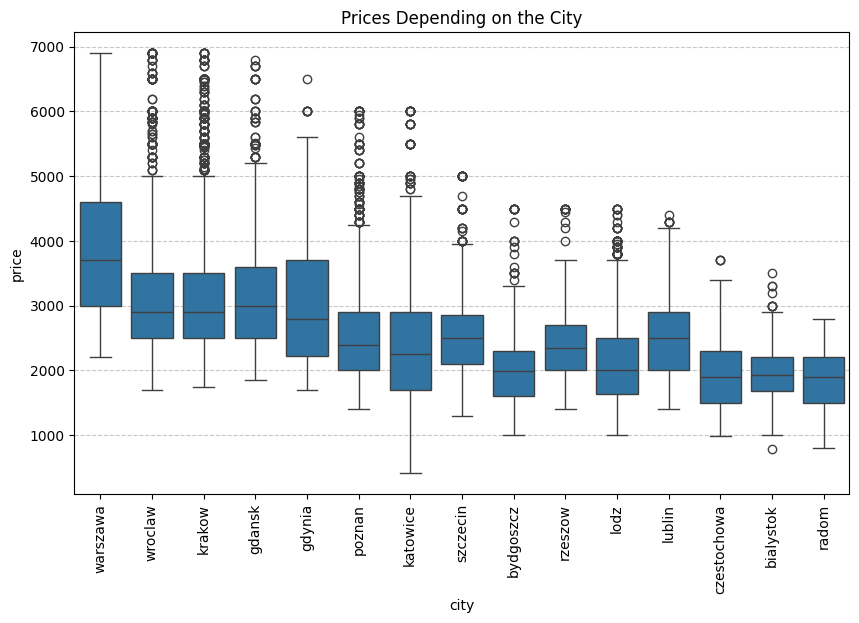

In [8]:


df_sorted = df.sort_values(by='price', ascending=False)
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price', data=df_sorted)

plt.xlabel('city')
plt.ylabel('price')
plt.title('Prices Depending on the City')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()



In [9]:
df=df.drop('city',axis=1)

In [22]:
df.head()

,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,28.60,1.0,10.0,10.0,53.446498,14.563188,2.57,8.0,0,0,1,0,0,0,0,1700
1,27.00,1.0,2.0,4.0,53.431103,14.542026,1.52,76.0,0,0,1,1,0,1,0,2300
2,47.55,2.0,3.0,10.0,53.434200,14.559100,1.21,25.0,1,0,1,0,0,0,0,2500
3,54.30,3.0,1.0,3.0,53.394000,14.492200,5.61,2.0,1,1,0,0,0,0,0,2600
4,31.00,1.0,6.0,8.0,53.432784,14.507945,3.66,14.0,0,0,1,0,1,0,0,2000


In [10]:


from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [27]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Создаем базовую модель RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Определяем сетку гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 30, 50, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем объект GridSearchCV с базовой моделью
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Обучаем модель на тренировочных данных
grid_search.fit(X_train, y_train)

# Получаем лучшую модель и выводим подобранные параметры
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

# Сохраняем лучшую модель в файл
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("Модель сохранена в 'best_random_forest_model.pkl'")



KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

MSE: 195848.07967515412
MAE: 300.9451600132374
R-squared: 0.8553674902753629


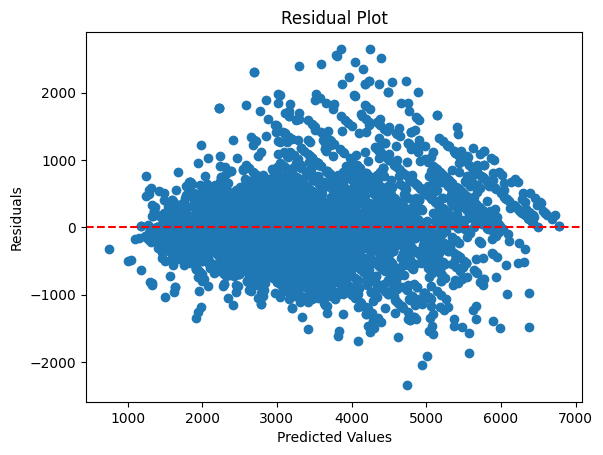

In [13]:


residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



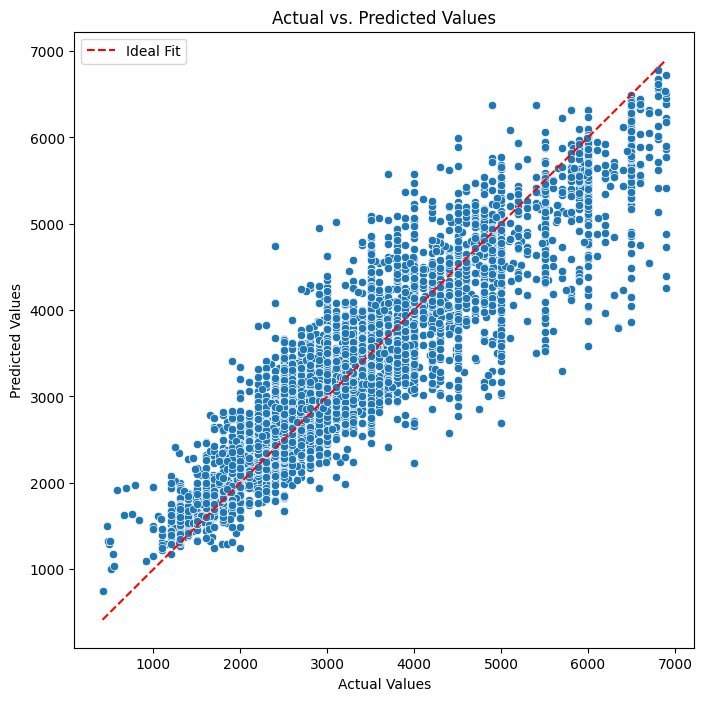

In [14]:


min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()



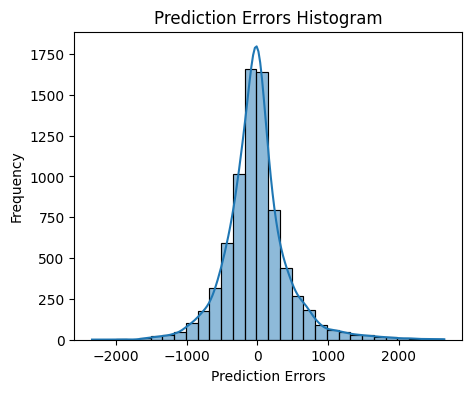

In [15]:
errors = y_test - y_pred

plt.figure(figsize=(5, 4))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Prediction Errors Histogram')
plt.show()

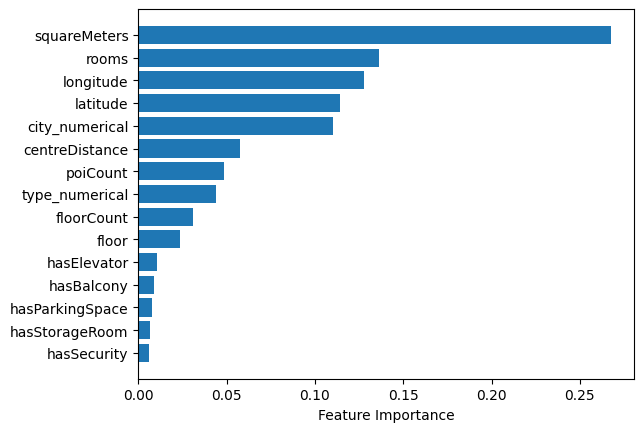

In [16]:
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [17]:
# used parameters
params = rf_model.get_params()

print("Random Forest model parameters:")
for param, value in params.items():
    print(f"{param}: {value}")

Random Forest model parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 50
max_features: sqrt
max_leaf_nodes: None
max_samples: 0.8
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: -1
oob_score: False
random_state: 42
verbose: 0
warm_start: False
